In [2]:
import cv2
import numpy as np
from matplotlib.path import Path
from scipy.sparse import dok_matrix, csc_matrix, lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt


## Task1: Region Filling

The objective of this task is to fill a selected region of a grayscale image by solving the poisson equation. The selected region, defined by a polygon, will be removed, and the intensity values(f) inside the region will be estimated based on boundary conditions provided by the rest of the image.

$$
\Delta f = 0 \quad \text{over} \quad \Omega \quad \text{with} \quad f|_{\partial \Omega} = f^*|_{\partial \Omega}
$$
Where:

- $\Delta$ is the Laplacian operator, which is defined as:
$$
  \Delta = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}
$$
-  $f$ represents the pixel intensity values of the image, and we aim to estimate the values of f inside the selected region, denoted by $\Omega$.
- The boundary conditions are provided by the known pixel values around the selected region, denoted as $f^*$ .


In [12]:
def mark_vertices(img):
    vertices = []

    %matplotlib widget
    fig, ax = plt.subplots()
    plt.imshow(img, cmap='gray')
    # onclick function gets called when mouse is clicked on the image
    def onclick(event): 
        if event.xdata is not None and event.ydata is not None:
            x, y = int(event.xdata), int(event.ydata)
            vertices.append([x, y])
            ax.scatter(x, y, color='red')
            fig.canvas.draw()

    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()
    
    return vertices

In [11]:
def region_fill(img, vertices):
    path = Path(vertices, closed=True)
    x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0])) # x = [0, 1, 2, ..., w-1], y = [0, 1, 2, ..., h-1]
    points = np.vstack((x.ravel(), y.ravel())).T # points = [[0, 0], [1, 0], ..., [w-1, h-1]]
    mask = path.contains_points(points).reshape(img.shape) # mask = [[True, False, True, ...], [False, True, False, ...], ...] True if points are inside the polygon else False
    
    region = np.argwhere(mask) # y, x coordinates 
    region_dic = {(y,x): i for i, (y,x) in enumerate(region)}
    n = len(region)
    
    # Create sparse matrix A and vector b for solving the discrete poisson equation
    A = dok_matrix((n, n), dtype=np.float32)
    b = np.zeros(n)

    # Fill the matrix A and vector b
    for idx, (i, j) in enumerate(region):
        A[idx, idx] = 4  # Set the diagonal element to 4
        neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
        
        for ni, nj in neighbors:
            k = region_dic.get((ni, nj)) # Get the index of the neighbor in the region
            if k is not None:
                A[idx, k] = -1 # If the neighbor is inside the region, set the corresponding element to -1
            else:
                b[idx] += img[ni, nj] # If the neighbor is outside the region, add the pixel value to the vector b
                    
    A = A.tocsc() # Convert the sparse matrix to compressed sparse column format for efficiency
    x = spsolve(A, b)
    filled_img = img.copy()
    filled_img[mask] = x.clip(0, 255)

    return filled_img


In [5]:
def plot_imgs(before, after, vertex):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(before, cmap='gray')
    polygon = plt.Polygon(vertex, edgecolor='r', facecolor='none')
    ax[0].add_patch(polygon)
    
    ax[1].imshow(after, cmap='gray')

## Smooth regions

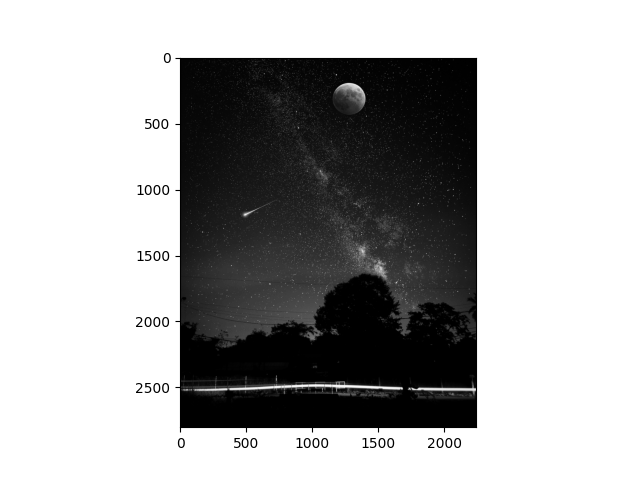

In [ ]:
gray_img = cv2.imread('img.jpg', cv2.IMREAD_GRAYSCALE)
vertices = mark_vertices(gray_img)
#vertices = [[1411, 51], [994, 149], [1116, 460], [1442, 490], [1601, 286]]

In [18]:
print(vertices)

[[1411, 51], [994, 149], [1116, 460], [1442, 490], [1601, 286]]


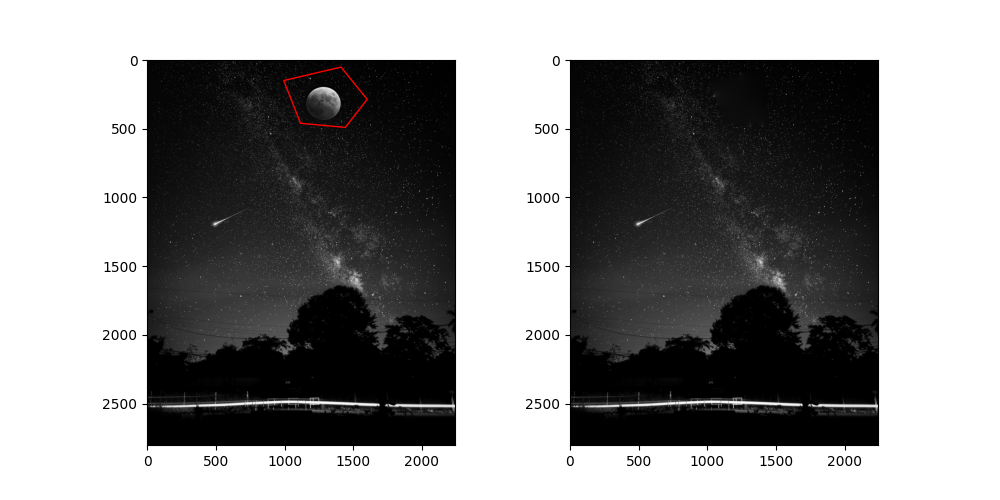

In [10]:
filled_img = region_fill(gray_img, vertices)
plot_imgs(gray_img, filled_img, vertices)

## High-frequency regions

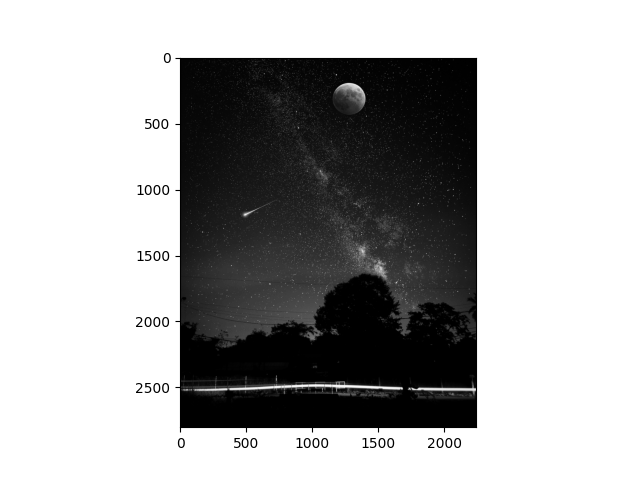

In [ ]:
vertices_1 = mark_vertices(gray_img)
#vertices_1 =[[1681, 1768], [1529, 1541], [1211, 1609], [1090, 1784], [1340, 1890], [1567, 1852]]

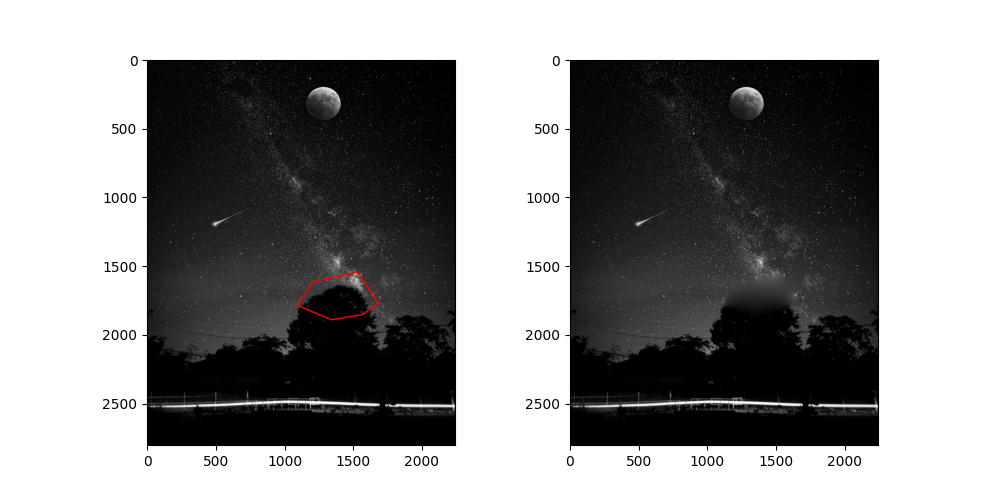

In [14]:
filled_img = region_fill(gray_img, vertices_1)
plot_imgs(gray_img, filled_img, vertices_1)

As the size of the selected region increases, the computation likely to become larger. This is because the algorithm needs to solve for the larger number of unknowns (intensity values) inside the mask.

For smooth regions, the filling appears natural and seamless, blending well with the surrounding pixels. However, in regions with high frequency or detailed textures, the filled areas appear unnatural or limited in maintaining textures.

## Task2: Seamless Cloning

Task 2 is performing seamless cloning on selected images using two methods.

a. Importing gradients. The gradient field v is taken directly from the source image and is defined as:

$$
\mathbf{v} = \nabla g
$$
b. Mixing gradients. The gradient field v is determined by comparing the gradients of the source image and the destination image at each point. Specifically, for each point x, the stronger gradient is selected as the guidance field v, according to the follwing rule:
$$
\mathbf{v} = 
\begin{cases}
\nabla f^*(x) & \text{if } |\nabla f^*(x)| > |\nabla g(x)| \\
\nabla g(x) & \text{otherwise}
\end{cases}
$$

The Poisson equation now becomes:
$$
\Delta f = \Delta g \quad \text{over} \quad \Omega \quad \text{with} \quad f|_{\partial \Omega} = f^*|_{\partial \Omega}
$$

In [19]:
def apply_gradient(src, dst, offset, vertices, mode):
    # Adjust vertices based on the offset and create a mask for the region
    adjusted_vertices = np.array(vertices) + offset

    path = Path(adjusted_vertices, closed=True)
    x, y = np.meshgrid(np.arange(src.shape[1]), np.arange(src.shape[0]))
    points = np.vstack((x.ravel(), y.ravel())).T
    mask = path.contains_points(points).reshape(src.shape)
    
    region = np.argwhere(mask) # y, x coordinates
    region_dic = {(y,x): i for i, (y,x) in enumerate(region)}
    n = len(region)
    
    # Create sparse matrix A and vector b for the Poisson equation
    A = dok_matrix((n, n), dtype=np.float32) 
    b = np.zeros(n)

    # Fill the matrix A and vector b
    for idx, (i, j) in enumerate(region):
        A[idx, idx] = 4  # Laplacian coefficient
        neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
        
        for ni, nj in neighbors:
            k = region_dic.get((ni, nj))
            if k is not None:
                A[idx, k] = -1
            else:
                b[idx] += dst[ni, nj]
        
            if mode == 'import':
                v = src[i - offset[1], j - offset[0]] - src[ni - offset[1], nj - offset[0]]
                b[idx] += v

            elif mode == 'mixed':
                v_src = src[i - offset[1], j - offset[0]] - src[ni - offset[1], nj - offset[0]]
                v_dst = dst[i, j] - dst[ni, nj]
                if abs(v_src) > abs(v_dst):
                    b[idx] += v_src
                else:
                    b[idx] += v_dst

    A_csc = A.tocsc() # Convert to Compressed Sparse Column format for efficiency
    new_values = spsolve(A_csc, b)

    # Construct the new image with the solved values
    new_img = dst.copy()
    new_img[mask] = new_values.clip(0, 1)

    return new_img

In [20]:
def plot_imgs_clone(source, target, new, vertex, offset):
    
    fig, ax = plt.subplots(1, 3, figsize=(10,5))
    ax[0].imshow(source, cmap='gray')
    ax[0].add_patch(plt.Polygon(vertex, edgecolor='r', facecolor='none'))
    
    new_vertex = np.array(vertex) + offset
    ax[1].imshow(target, cmap='gray')
    ax[1].add_patch(plt.Polygon(new_vertex, edgecolor='r', facecolor='none'))
    
    ax[2].imshow(new, cmap='gray')
    plt.show()

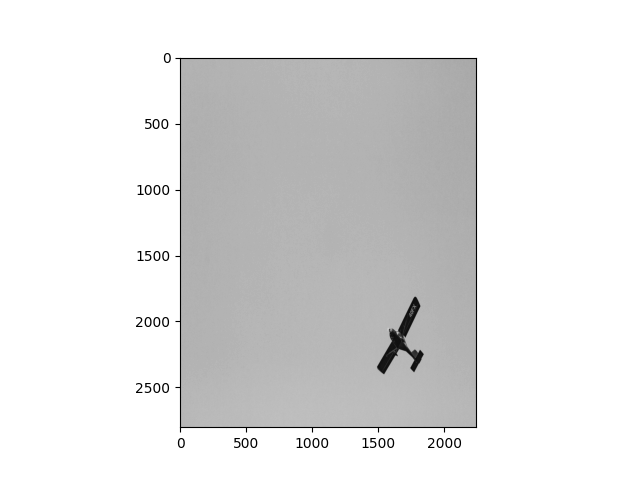

In [22]:
source = cv2.imread('img2.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
target = cv2.imread('img.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# Resize source to match target dimensions
source_resized = cv2.resize(source, (target.shape[1], target.shape[0]))

vertices = mark_vertices(source_resized)
#vertices = [[1517, 2014], [1548, 2158], [1457, 2348], [1540, 2454], [1669, 2234], [1745, 2302], [1699, 2386], [1775, 2454], [1904, 2227], [1836, 2173], [1760, 2211], [1707, 2128], [1836, 1870], [1783, 1741], [1639, 2014]]



## 2-a Importing gradient

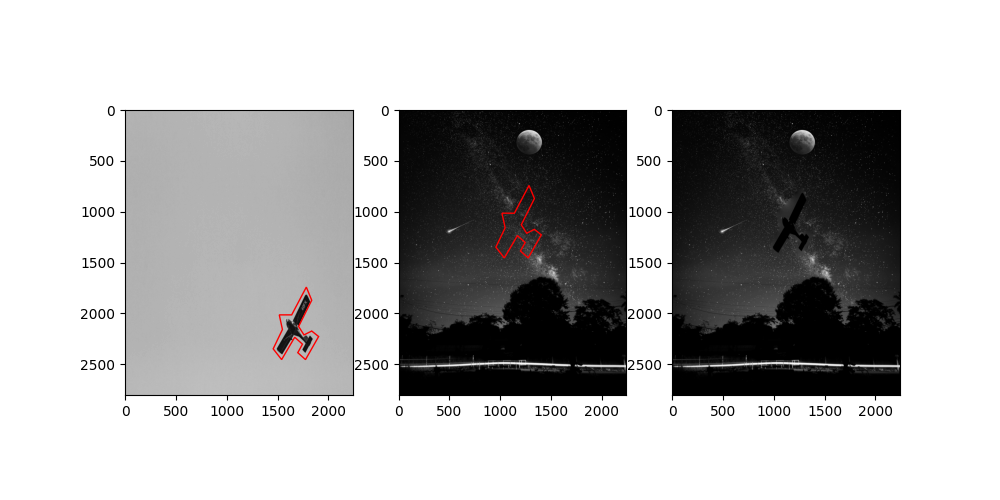

In [23]:
offset = np.array([-500, -1000])

new_img_import = apply_gradient(source_resized, target, offset, vertices, mode='import')
plot_imgs_clone(source_resized, target, new_img_import, vertices, offset)

## 2-b Mixing gradient

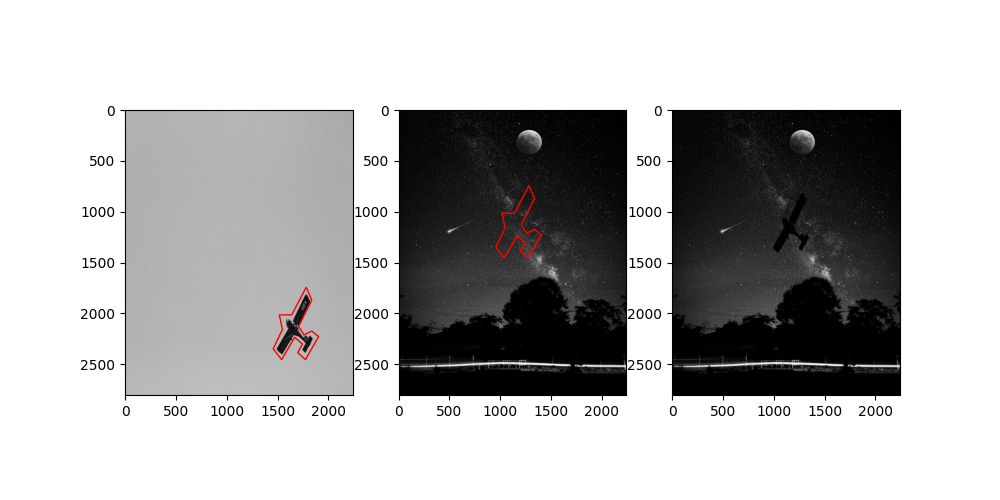

In [24]:
new_img_mixed = apply_gradient(source_resized, target, offset, vertices, mode='mixed')
plot_imgs_clone(source_resized, target, new_img_mixed, vertices, offset)

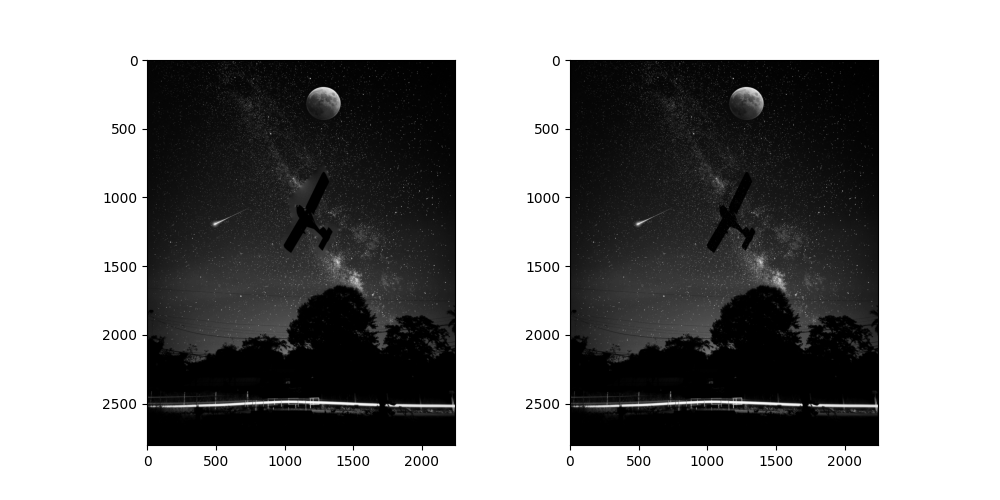

In [25]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(new_img_import, cmap='gray')
ax[1].imshow(new_img_mixed, cmap='gray')

The left image shows the airplane copied into the background, creating a less natural transition, while the right image, using mixing gradient, achieve a more seamless cloning.

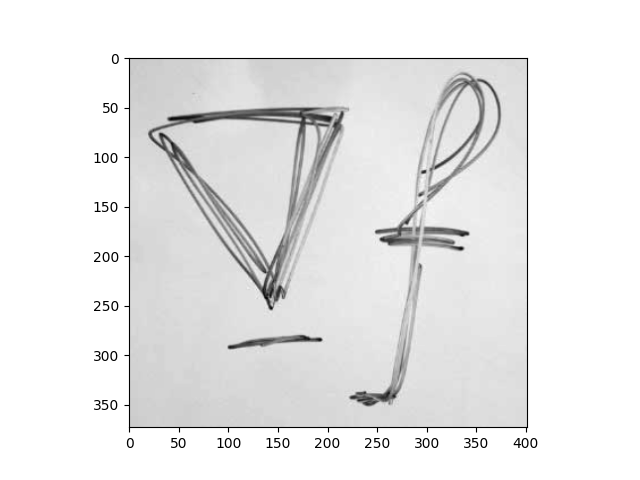

In [ ]:
img3 = cv2.imread('img3.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
img4 = cv2.imread('img4.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

img4_resized = cv2.resize(img4, (img3.shape[1], img3.shape[0]))
vertices_img4 = mark_vertices(img4_resized)
# vertices_img4 = [[239, 38], [19, 48], [8, 84], [118, 249], [78, 303], [201, 292], [209, 264], [175, 238], [228, 61], [288, 63], [308, 17], [374, 16], [382, 86], [352, 190], [291, 349], [251, 360], [206, 345], [253, 309], [263, 225], [237, 178], [267, 140], [278, 94]]


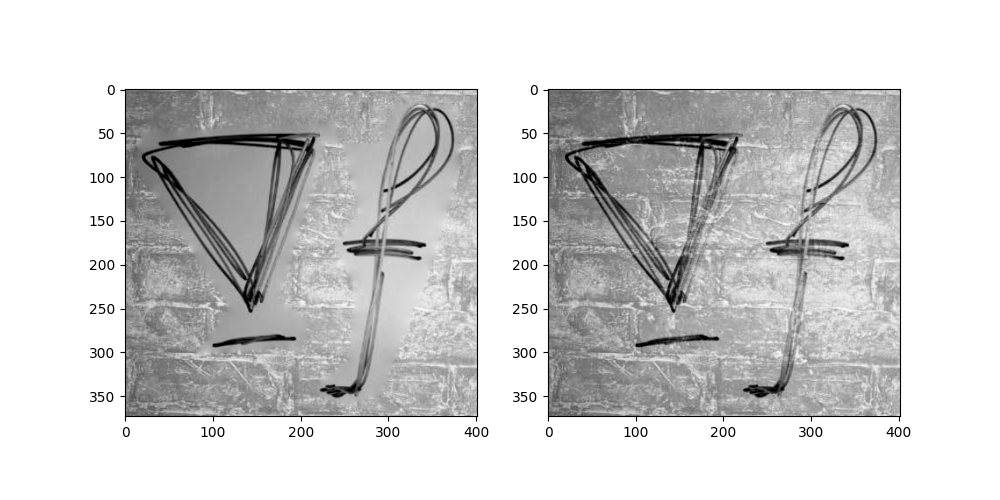

In [60]:
offset = np.array([0, 0])
img4_import = apply_gradient(img4_resized, img3, offset, vertices_img4, mode='import')
img4_mixed = apply_gradient(img4_resized, img3, offset, vertices_img4, mode='mixed')

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img4_import, cmap='gray')
ax[1].imshow(img4_mixed, cmap='gray')

Normal seamless cloning does not perform well when inserting objects with holes, leading to blurred portions in the target image. However, mixed gradients method is effective by better preserving the clarity of the target area.

# Task3: Colored Images

In [31]:
def apply_gradient_color(src, dst, offset, vertices, mode):
    channels = []
    # process the RGB channels separately
    for i in range(3):
        src_channel = src[:, :, i]
        dst_channel = dst[:, :, i]
        new_img_channel = apply_gradient(src_channel, dst_channel, offset, vertices, mode)
        channels.append(new_img_channel)
    
    return np.stack(channels, axis=-1)  # axis=-1 combine the channels along the last dimension


In [32]:
color_img = cv2.imread('img.jpg', cv2.IMREAD_COLOR).astype(np.float32) / 255.0
color_img2 = cv2.imread('img2.jpg', cv2.IMREAD_COLOR).astype(np.float32) / 255.0
color_img2_resized = cv2.resize(color_img2, (color_img.shape[1], color_img.shape[0]))

color_img2_resized = color_img2_resized[..., ::-1]
color_img = color_img[..., ::-1] # ::-1 is to reverse the order of the channels (BGR to RGB)
vertices = [[1517, 2014], [1548, 2158], [1457, 2348], [1540, 2454], [1669, 2234], [1745, 2302], [1699, 2386], [1775, 2454], [1904, 2227], [1836, 2173], [1760, 2211], [1707, 2128], [1836, 1870], [1783, 1741], [1639, 2014]]


In [33]:
offset = np.array([-500, -1000])
color_img_import = apply_gradient_color(color_img2_resized, color_img, offset, vertices, mode='import')
color_img_mixed = apply_gradient_color(color_img2_resized, color_img, offset, vertices, mode='mixed')

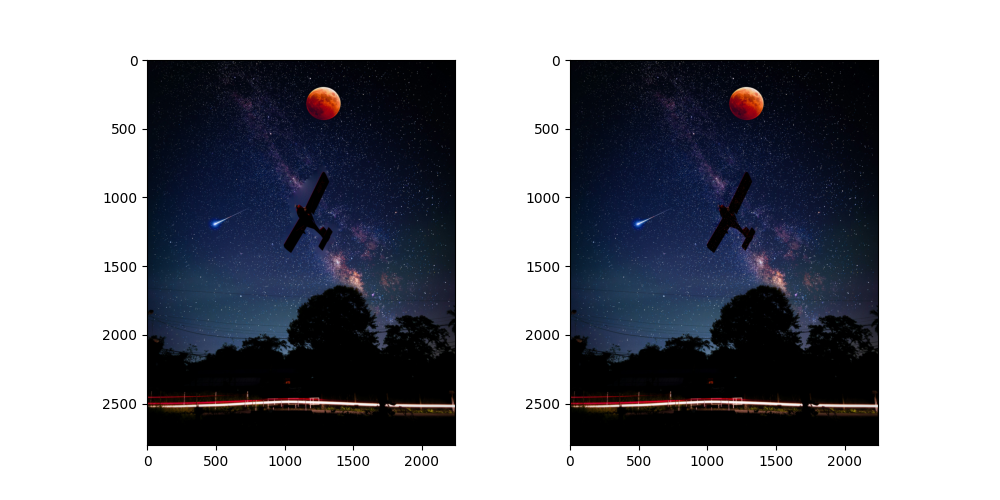

In [34]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(color_img_import, cmap='gray')
ax[1].imshow(color_img_mixed, cmap='gray')

In [35]:
img3 = cv2.imread('img3.jpg', cv2.IMREAD_COLOR).astype(np.float32) / 255.0
img4 = cv2.imread('img4.jpg', cv2.IMREAD_COLOR).astype(np.float32) / 255.0
img4_resized = cv2.resize(img4, (img3.shape[1], img3.shape[0]))
img4_resized = img4_resized[..., ::-1]
img3 = img3[..., ::-1]

offset = np.array([0, 0])
color_img4_import = apply_gradient_color(img4_resized, img3, offset, vertices_img4, mode='import')
color_img4_mixed = apply_gradient_color(img4_resized, img3, offset, vertices_img4, mode='mixed')


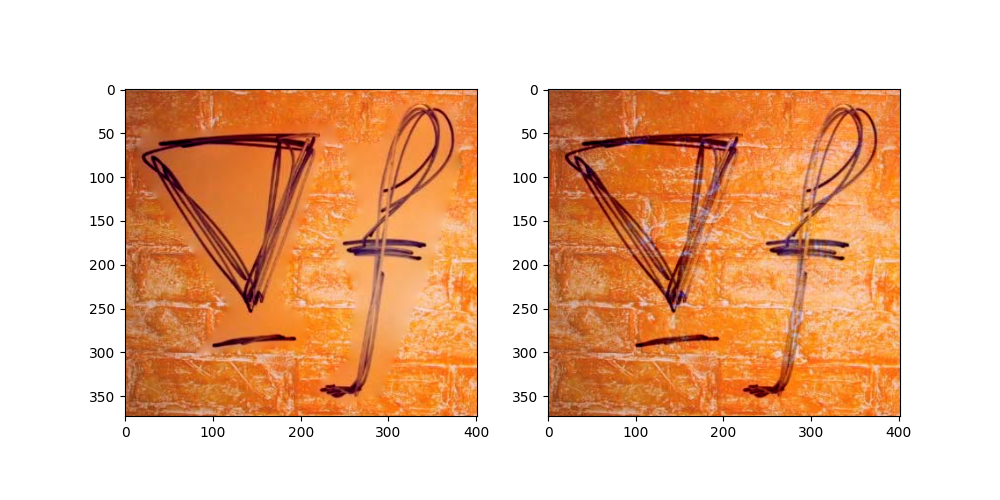

In [36]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(color_img4_import, cmap='gray')
ax[1].imshow(color_img4_mixed, cmap='gray')

# Task4: Local Color Changes

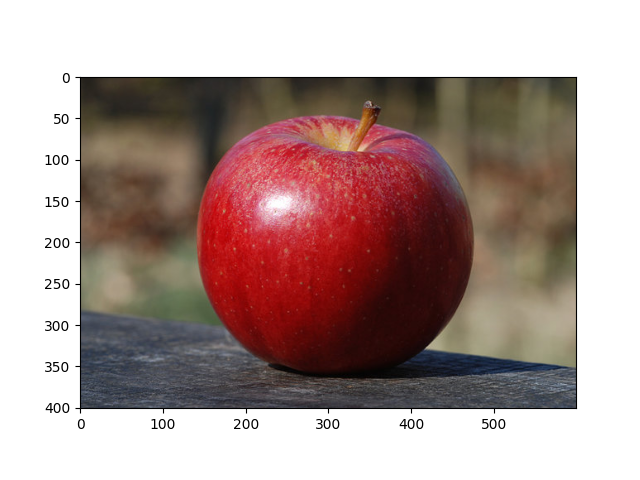

In [50]:
img5 = cv2.imread('img5.jpg', cv2.IMREAD_COLOR).astype(np.float32) / 255.0
img5 = img5[..., ::-1]  # Convert BGR to RGB 
vertices_img5 = mark_vertices(img5)
#vertices_img5 = [[279, 45], [228, 58], [182, 82], [154, 125], [139, 183], [141, 233], [156, 277], [186, 316], [224, 345], [261, 358], [308, 359], [385, 353], [429, 322], [463, 271], [475, 221], [477, 180], [464, 137], [442, 97], [413, 69], [373, 56], [355, 50], [364, 34], [343, 31], [335, 47], [307, 43]]

In [51]:
print(vertices_img5)

[[279, 45], [228, 58], [182, 82], [154, 125], [139, 183], [141, 233], [156, 277], [186, 316], [224, 345], [261, 358], [308, 359], [385, 353], [429, 322], [463, 271], [475, 221], [477, 180], [464, 137], [442, 97], [413, 69], [373, 56], [355, 50], [364, 34], [343, 31], [335, 47], [307, 43]]


In [56]:

from skimage.draw import polygon

def show_color_changes(img, vertices):
   fig, axes = plt.subplots(1, 3, figsize=(10, 5))
   
   # Left: Original image with selection
   axes[0].imshow(img)
   poly = plt.Polygon(vertices, fill=False, color='red')
   axes[0].add_patch(poly)
   axes[0].set_title('Original with Selection')
   
   # Center: Background decolorization
   # Apply decolorization: Set saturation to 0 and use the value(luminance) channel for background
   rr, cc = polygon([v[1] for v in vertices], [v[0] for v in vertices], img.shape[:2])
   mask = np.zeros(img.shape[:2], dtype=bool)
   mask[rr, cc] = True
   
   decolor = img.copy()
   hsv = cv2.cvtColor(decolor, cv2.COLOR_RGB2HSV) # Convert to HSV color space, where H is hue, S is saturation, and V is value
   
   hsv[~mask, 1] = 0  # Set saturation to 0 for background
   hsv[~mask, 2] = hsv[:, :, 2][~mask]
   
   decolorized = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
   axes[1].imshow(decolorized)
   axes[1].set_title('Background Decolorization')

   # Right: Recolored object
   # Add the hue shift, and then take modulo 180
   recolor = img.copy()
   hsv = cv2.cvtColor(recolor, cv2.COLOR_RGB2HSV)
   hue_shift = 100  # can change this value to get different color shifts
   hsv[mask, 0] = (hsv[mask, 0] + hue_shift) % 180 
   hsv[mask, 0] = hsv[mask, 0].astype(np.uint8)
   
   axes[2].imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)) 
   axes[2].set_title('Recolored Object')
   
   plt.tight_layout()
   plt.show()
   
   

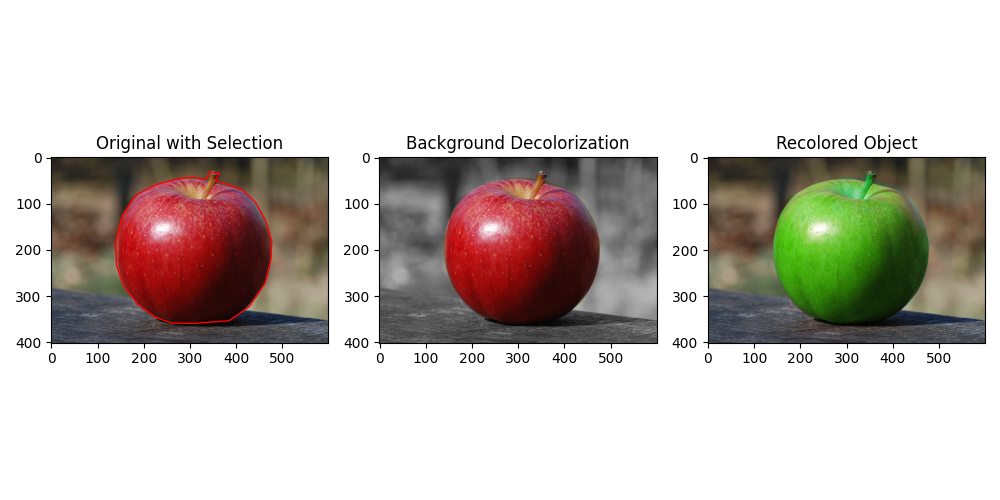

In [57]:
show_color_changes(img5, vertices_img5)


1. Original with selection: The original image is displayed with the selected region (Ω) loosely 
surrounding the object of interest.
2. Background decolorization: The destination image is set to be the luminance channel from the original image using the HSV color space,
while keeping the color of the selected region.
3. Recolored object: Instead of directly modifying the RGB channels, the hue component in the HSV color space is adjusted to alter the object's color. This aviods the distortions with RGB manipulations, resulting in a more natural color shift.

Using RGB channels multiplication for color changes does not ensure a perfect segmentation, often resulting in residual color contamination of the destination image outside the object.